In [1]:
%matplotlib inline
import openmc
import numpy as np

In [2]:
# Define materials

# Fresh Fuel
uo2 = openmc.Material(name="uo2")
# Check U enrichment as a weight percentage???
uo2.add_nuclide('U235', 0.04)
uo2.add_nuclide('U238', 0.96)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.5)

# Zircaloy
zircaloy = openmc.Material(name="zircaloy")
zircaloy.add_nuclide('Cr52', 7.589e-5)
zircaloy.add_nuclide('Fe56', 1.484e-4)
zircaloy.add_nuclide('Zr90', 4.298e-2)

# Water
water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
# above only uses free-atom cross sections - use an S(α,β) table so that the bound atom cross section is used at thermal energies
water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([uo2, zircaloy, water])
materials.export_to_xml()

In [3]:
# Define geometry

fuel_length = 365.76
bottom = openmc.ZPlane(z0=-fuel_length/2, boundary_type = 'vacuum')
top = openmc.ZPlane(z0=fuel_length/2, boundary_type = 'vacuum')
pitch = 1.26
fuel_pin_box = openmc.model.RectangularPrism(width=pitch, height=pitch)

In [4]:
# Define fuel pin geometry

fuel_outer_radius = openmc.ZCylinder(r=0.8166/2, boundary_type = 'vacuum')
clad_inner_radius = openmc.ZCylinder(r=0.833/2, boundary_type = 'vacuum')
clad_outer_radius = openmc.ZCylinder(r=0.955/2, boundary_type = 'vacuum')

fuel_region = -fuel_outer_radius & -top & +bottom
gap_region = +fuel_outer_radius & -clad_inner_radius & -top & +bottom
clad_region = +clad_inner_radius & -clad_outer_radius & -top & +bottom
water_region = -fuel_pin_box & +clad_outer_radius 

fuel = openmc.Cell(name='fuel')
fuel.fill = uo2
fuel.region = fuel_region

# assume that gap fills with water
gap = openmc.Cell(name='gap')
gap.fill = water
gap.region = gap_region

clad = openmc.Cell(name='clad')
clad.fill = zircaloy
clad.region = clad_region

moderator = openmc.Cell(name='moderator')
moderator.fill = water
moderator.region = water_region

fuel_pin_univ = openmc.Universe(cells=[fuel, gap, clad, moderator], name = 'filled')

In [5]:
# Define empty channel geometry

ec_water_region = -fuel_pin_box & -top & +bottom

moderator = openmc.Cell(name='moderator')
moderator.fill = water
moderator.region = ec_water_region

ec_univ = openmc.Universe(cells=[moderator], name = 'empty')

In [6]:
# 17x17 array of fuel pins with empty positions (x,y):
# (6,3),(9,3),(12,3),
# (4,4),(14,4),
# (3,6),(6,6),(9,6),(12,6),(15,6),
# (3,9),(6,9),(9,9),(12,9),(15,9),
# (3,12),(6,12),(9,12),(12,12),(15,12),
# (4,14),(14,14),
# (6,15),(9,15),(12,15)

pin_arr = np.full((17,17), fuel_pin_univ)

# row 3
pin_arr[2][5] = pin_arr[2][8] = pin_arr[2][11] = ec_univ
# row 4
pin_arr[3][3] = pin_arr[3][13] = ec_univ
# row 6
pin_arr[5][2] = pin_arr[5][5] = pin_arr[5][8] = pin_arr[5][11] = pin_arr[5][14] = ec_univ
# row 9
pin_arr[8][2] = pin_arr[8][5] = pin_arr[8][8] = pin_arr[8][11] = pin_arr[8][14] = ec_univ
# row 12
pin_arr[11][2] = pin_arr[11][5] = pin_arr[11][8] = pin_arr[11][11] = pin_arr[11][14] = ec_univ
# row 14
pin_arr[13][3] = pin_arr[13][13] = ec_univ
# row 15
pin_arr[14][5] = pin_arr[14][8] = pin_arr[14][11] = ec_univ

In [7]:
# Define assembly

total_pitch = pitch * 17
lattice = openmc.RectLattice()
lattice.lower_left = (-total_pitch/2,-total_pitch/2)
lattice.pitch = (pitch,pitch)
lattice.outer = ec_univ
lattice.universes = pin_arr

print(lattice)

RectLattice
	ID             =	3
	Name           =	
	Shape          =	(17, 17)
	Lower Left     =	(-10.71, -10.71)
	Pitch          =	(1.26, 1.26)
	Outer          =	2
	Universes      
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 
1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 2 1 1 2 1 1 2 1 1 2 1 1 2 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 2 1 1 2 1 1 2 1 1 2 1 1 2 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 2 1 1 2 1 1 2 1 1 2 1 1 2 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 
1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

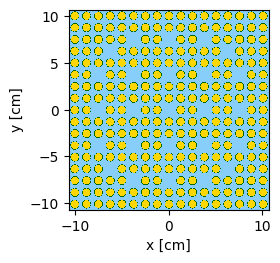

In [25]:
assembly = openmc.Cell(fill=lattice)
geometry = openmc.Geometry([assembly])
geometry.plot(width=(total_pitch, total_pitch), color_by = 'material',
              colors = {uo2: 'gold', zircaloy: 'darkgreen', water: 'lightskyblue'})